## Step 0: Importing the Appropriate Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
import emcee
import corner
import os
import glob

import astropy.constants as ac
from astropy import units as u
from astropy.convolution import Gaussian1DKernel, convolve
from astropy.modeling import models
from astropy.visualization import quantity_support
from scipy.optimize import minimize
from scipy import interpolate

## Step 1: Importing Data and Changing the Units of the Variables

We'll first import and read the following data:

1. chen+07_slshlh.dat; This contains the Spitzer IRS spectrum of BetaPic from ~5-35 microns. 

2. betapic_fluxes.dat; This contains assorted photometry from the optical and infrared with BetaPic. 

3. betapic_lws_cnt3_.txt; This contains the ISO LWS spectrum of BetaPic, from ~43 to 160 microns.

### 1.1: Using the correct folders to pull the data from and to put the data in

In [2]:
# first the main directory
cwd = os.getcwd()

# then the appropriate folders inside this main directory
Photom_IRS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic" # where the photometry and IRS Spectrum is found
LWS = cwd + "\\data\\betapic_data\DiskModels\Debris\BetaPic\iso\hpdp_62003530_3" # where the LWS Spectrum is found

Ice = cwd + "\\data\\water_ice_opacities_lsbrp" # where the different opacity files are found
Silicates = cwd + "\\data\\silicates_for_betapic" # where the different silicate files are found

### 1.2: Importing the Data 

In [3]:
# Changing directory to the photometry and IRS Spectrum files
os.chdir(Photom_IRS)

# Columns are all labelled (wavelength in microns, flux (F_nu) and uncertainty in Janskys, (Jy)).
Spitzer_IRS = np.loadtxt('chen+07_slshlh.dat')
Wavelength_IRS, Flux_IRS_Jy, Error_IRS_Jy = Spitzer_IRS[:,0], Spitzer_IRS[:,1], Spitzer_IRS[:,2]

# Columns are formatted as wavelength (mircons), flux (F_nu, Jy), uncertainty (Jy).
Photom = np.loadtxt('betapic_fluxes.dat')
Wavelength_Photom, Flux_Photom_Jy, Error_Photom_Jy = Photom[:,0], Photom[:,1], Photom[:,2]


# Changing directory to the LWS Spectrum file
os.chdir(LWS)

# Columns are formatted  as wavelength (microns), nu*F_nu (erg/cm^2/s), and uncertainty in nu*F_nu (same units).
ISO_LWS = np.loadtxt('betapic_lws_cnt3_.txt')
Wavelength_LWS, Flux_LWS, Error_LWS = ISO_LWS[:,0], ISO_LWS[:,1], ISO_LWS[:,2]

### 1.3: Rewriting the units
We need to convert the fluxes and error from Jansky to erg cm$^{-2}$ s$^{-1}$ . We know that 1 Jy equals to 10$^{23}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$.

Such that we get: erg cm$^{-2}$ s$^{-1}$ = 10$^{-23}$ Hz Jy

In [4]:
# We can now calculate the flux using F = v*F_v (also making sure that the wavelength is in meters and not in microns)
Flux_IRS = 10**(-23)*Flux_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Flux_Photom = 10**(-23)*Flux_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

# We can now also calculate the error in the fluxes
Error_IRS = 10**(-23)*Error_IRS_Jy*(ac.c.value/(Wavelength_IRS*10**(-6)))
Error_Photom = 10**(-23)*Error_Photom_Jy*(ac.c.value/(Wavelength_Photom*10**(-6)))

In [5]:
# Making sure no flux is zero/negative
Flux_IRS, Wavelength_IRS, Error_IRS = Flux_IRS[Flux_IRS>0], Wavelength_IRS[Flux_IRS>0], Error_IRS[Flux_IRS>0]
Flux_Photom, Wavelength_Photom, Error_Photom = Flux_Photom[Flux_Photom>0], Wavelength_Photom[Flux_Photom>0], Error_Photom[Flux_Photom>0]

# Removing the negative values
Flux_LWS, Wavelength_LWS, Error_LWS = Flux_LWS[Flux_LWS>0], Wavelength_LWS[Flux_LWS>0], Error_LWS[Flux_LWS>0]

# Removing the error equal to 0 from the photometry
Error_Photom, Flux_Photom, Wavelength_Photom = Error_Photom[Error_Photom!=0], Flux_Photom[Error_Photom!=0], Wavelength_Photom[Error_Photom!=0]

We need to convolve LWS Spectrum to smoothen it

In [6]:
# Create kernel & convolving lWS spectrum
g = Gaussian1DKernel(stddev=3)
z = convolve(Flux_LWS, g)

# Removing the tail of the LWS spectrum [by trial and error]
Wavelength_z, z, Error_z = Wavelength_LWS[6:], z[6:], Error_LWS[6:]

## Figures

In [7]:
def spectrum(wave, x0):
    """Calculates the flux as (v*F_v [v = frequency]) for a given temperature and 
    a given solid angle. This model is equal to a blackbody"""
    T, SolidAngle = x0

    bb = models.BlackBody(temperature=T*u.K)
    B_q = bb(wave*u.micron)
    
    F = ((SolidAngle*10**(-13))*u.sr)*B_q*(ac.c/(wave*u.micron))
    return F.to(u.erg * u.cm**(-2) * u.s**(-1)).value

In [8]:
# Creating the BlackBodies of the different fits
wave = np.arange(0.1,3000,0.001)
x0_BetaPic = [8200, 1.2699*10**(-17)*10**(13)]

x0 = [139.00859572059318, 3.1809713084940037] # From Part 2 (MCMC Fit)


F_BetaPic = spectrum(wave, x0_BetaPic)
F_d_MCMC = spectrum(wave, x0)

C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\SPJHe\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Figure size 432x288 with 0 Axes>

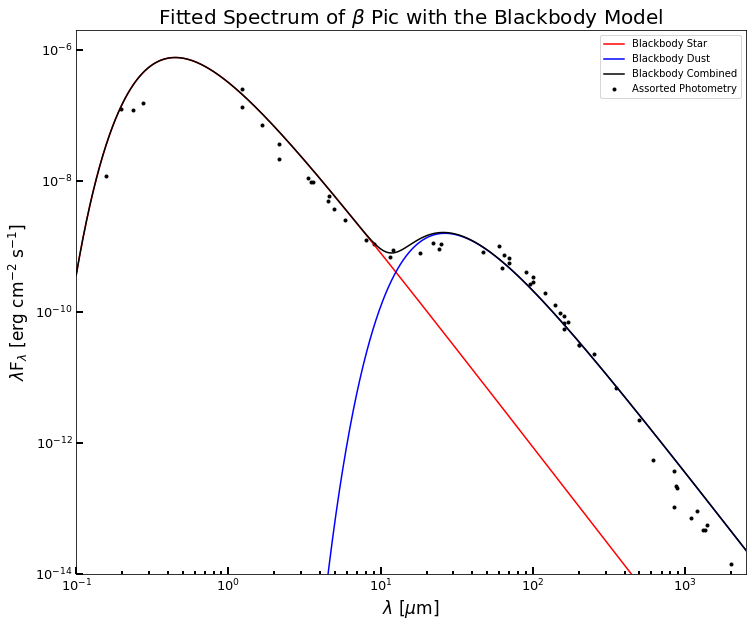

In [9]:
# Making sure that the figure will be saved in the main directory
os.chdir(cwd)

plt.figure()
plt.figure(figsize = (12,10))

plt.title(r"Fitted Spectrum of $\beta$ Pic with the Blackbody Model", fontsize = 20)
plt.xlabel("$\lambda$ [$\mu$m]", fontsize = 17)
plt.ylabel("$\lambda$F$_{\lambda}$ [erg cm$^{-2}$ s$^{-1}$]", fontsize = 17)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-1), 2.5*10**(3))
plt.ylim(10**(-14), 2*10**(-6))

plt.tick_params(which = 'minor', direction = 'in', length = 3, width = 2)
plt.tick_params(which = 'major', direction = 'in', length = 7, width = 2)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.plot(wave, F_BetaPic, color = "red", label = "Blackbody Star")

plt.plot(wave, F_d_MCMC, color = "blue", label = "Blackbody Dust")

plt.plot(wave, (F_BetaPic+F_d_MCMC),\
         color = "black", label = "Blackbody Combined")
plt.scatter(Wavelength_Photom, Flux_Photom, color = 'black', marker = '.', label = 'Assorted Photometry')

plt.legend(loc = 'upper right')

plt.show()
plt.close()